In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
from train import features, preprocess
from src.utils import scale_scores
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
production_df = pkl.load(open('../../data/production-results/2020-08-05_full-customer-model-data.pickle', 'rb')) #pd.read_csv('../../data/production-results/risk_group_run_20200805.csv')

In [3]:
production_df.head()

,party_id,request_source,model_score,model_decision_rule_details,customer_model_risk_group,proxy_id,old_rules_risk_group,created_dt,updated_dt,first_deposit_amount,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,14430639,scheduled,622.6139380865663,"[{'ruleName': 'isMember', 'rulePassed': False,...",RG5,20200805071117_68f3fc94-3ff4-4b39-892c-4dc3446...,RG4,2020-08-05 07:11:18.039863+00:00,NaT,50.0,...,0.0,1.0,0.0,0.0,150.0,0.0409,28.0,1,-1.0,-1.0
1,15964134,scheduled,652.0024132746818,"[{'ruleName': 'isMember', 'rulePassed': False,...",RG5,20200805071117_2a3091f6-d098-4b0b-9641-0c795e4...,RG5,2020-08-05 07:11:18.062526+00:00,NaT,-1.0,...,-1.0,0.0,0.0,0.0,2497.0,0.0833,NaN,0,-1.0,-1.0
2,16162300,scheduled,595.8207655584088,"[{'ruleName': 'isMember', 'rulePassed': False,...",RG4,20200805071118_493daba9-b63f-422a-9b59-482c33c...,RG3,2020-08-05 07:11:18.289105+00:00,NaT,-1.0,...,-1.0,0.0,0.0,0.0,7574.0,0.0354,39.0,0,-1.0,-1.0
3,16377895,scheduled,631.3250223505131,"[{'ruleName': 'isMember', 'rulePassed': False,...",RG5,20200805071117_96922fef-0514-4fb4-ae69-56b432a...,RG5,2020-08-05 07:11:18.065103+00:00,NaT,-1.0,...,-1.0,0.0,0.0,0.0,2866.0,0.0212,11.0,0,-1.0,-1.0
4,16419612,scheduled,660.1678061261076,"[{'ruleName': 'isMember', 'rulePassed': False,...",RG5,20200805071118_a94c95af-3c6a-4aa7-8367-c8ae485...,RG5,2020-08-05 07:11:18.197627+00:00,NaT,-1.0,...,-1.0,0.0,0.0,0.0,0.0,0.0367,6.0,0,-1.0,997.0


<AxesSubplot:>

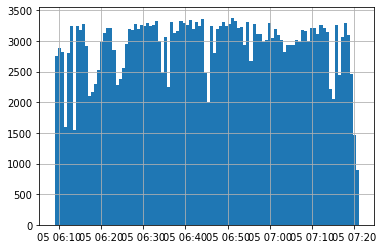

In [4]:
production_df['created_dt'] = pd.to_datetime(production_df.created_dt)
production_df.created_dt.hist(bins=100)

In [5]:
validation_df = pd.read_feather('../../data/combined_all_features/combined_1598485606.feather')
banking_df = pd.read_feather('../../data/processed/processed_1597860707/banking_accounts_1597860707.feather')

In [6]:
full_uid = banking_df.user_id.unique()
val_uid = validation_df.user_id.unique()
prd_uid = production_df.party_id.unique()
shared_uid = set(val_uid).intersection(set(prd_uid))

In [7]:
static_df = pd.read_feather('../../data/labeled/labeled_1597868133.feather')
dynamic_df = pd.read_feather('../../data-transactional/labeled/labeled_1597867828.feather')

In [8]:
unfilter_uid = np.concatenate([static_df.user_id.unique(), dynamic_df.user_id.unique()])
unfilter_uid = list(set(unfilter_uid))

In [9]:
len(unfilter_uid), len(prd_uid), len(set(unfilter_uid).intersection(set(prd_uid))), len(set(full_uid).intersection(set(prd_uid)))

(278075, 294626, 220697, 294570)

---
Checkout on data. We used party_id as the unique idenitifier in production, which is equivalent to user_id in our data pipeline. Just rerun the pipeline to carry out static sampling method on 8/5/2020.

In [10]:
df = pd.read_feather('../../data/combined_all_features/combined_1598485606.feather')
production_df = pd.read_csv('../../data/production-results/risk_group_run_20200805.csv')

In [11]:
df.shape, df.user_id.nunique(), df.sample_date.value_counts().head()

((1834871, 106),
 304131,
 2020-08-06 00:00:00    292047
 2020-08-05 00:00:00    289191
 2020-08-04 00:00:00    286387
 2019-11-29 05:57:03      1962
 2019-12-27 06:15:33      1844
 Name: sample_date, dtype: int64)

<AxesSubplot:>

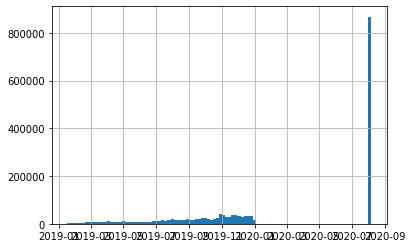

In [12]:
df.sample_date.hist(bins=100)

In [13]:
modeling_df = df[df.sample_date > pd.to_datetime('2020-08-02')]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']

In [14]:
# data from db
modeling_df.shape, modeling_df.user_id.nunique()

((867625, 107), 292174)

In [15]:
# data from production
production_df.shape, production_df.party_id.nunique()

((294626, 7), 294626)

In [16]:
shared_ids = set(modeling_df.party_id).intersection(set(production_df.party_id))
n_ids = len(shared_ids)
n_ids, n_ids/production_df.party_id.nunique(), n_ids/modeling_df.party_id.nunique()

(284613, 0.9660145404682546, 0.9741215850828616)

A small group of data is missing, since it is such a percentage, lets move onto generating scores first

---
### Get model and predict on shared data
- [ ] pull data on surrounding days and check ids

In [31]:
import pickle as pkl



In [32]:
import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
from train import features, preprocess
from src.utils import scale_scores
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [34]:
modeling_df = df[df.sample_date == pd.to_datetime('2020-08-04')]
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])
display(modeling_df.shape)
pkl.dump(modeling_df, open('modeling_df_with_pred_and_score.pkl', 'wb'))

(286387, 111)

In [14]:
df_ = modeling_df[features]
df_['nr_na'] = df_.isna().sum(axis=1)
modeling_df['party_id'] = modeling_df['user_id']

In [15]:
modeling_df.shape, modeling_df.sample_date.unique()

((286387, 110),
 array(['2020-08-04T00:00:00.000000000'], dtype='datetime64[ns]'))

In [16]:
modeling_df['valid_pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['valid_score'] = scale_scores(modeling_df['valid_pred'])

In [17]:
prd_cols = ['party_id', 'model_score']
val_cols = ['party_id', 'valid_pred', 'valid_score', 'nr_past_transactions']
result_df = pd.merge(production_df[prd_cols], modeling_df[val_cols], left_on='party_id', right_on='party_id', how='inner')

In [18]:
result_df.head(), result_df.shape

(   party_id  model_score  valid_pred  valid_score  nr_past_transactions
 0  14430639   622.613938    0.353013   613.278685                   2.0
 1  15964134   652.002413    0.635422   649.063422                   0.0
 2  16377895   631.325022    0.437646   624.220222                   0.0
 3  16419612   660.167806    0.715426   660.351206                   0.0
 4  16418214   668.854514    0.685361   655.933628                   0.0,
 (284443, 5))

In [19]:
modeling_df.columns[modeling_df.columns.str.contains('next')]

Index(['account_closed_by_risk_in_next_90d',
       'last_unrestricted_date_in_next_90d', 'nr_returns_in_next_90d'],
      dtype='object')

In [20]:
result_df = result_df[result_df.nr_past_transactions>0]

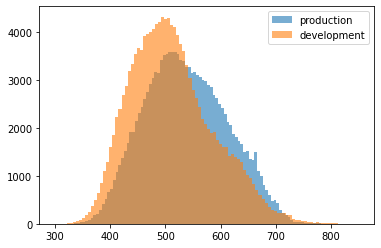

In [21]:
import matplotlib.pyplot as plt

plt.hist(result_df.model_score, alpha=0.6, bins=100, label='production')
plt.hist(result_df.valid_score, alpha=0.6, bins=100, label='development')
plt.legend()
plt.savefig('score_distribution.png')

In [23]:
from scipy.stats import iqr

result_df['score_diff'] = result_df.model_score - result_df.valid_score
(iqr(result_df.score_diff, rng=(5,95)), 
 math.sqrt(mean_squared_error(result_df.model_score, result_df.valid_score)),
 mean_absolute_error(result_df.model_score, result_df.valid_score))

(93.60834631232203, 39.851950626477, 30.722764647377296)

In [90]:
result_df[result_df.model_score.between(640,680)].model_score.value_counts()

661.184667    227
660.680477     13
661.528707      5
672.436254      3
670.216053      2
             ... 
648.967889      1
654.650467      1
651.167872      1
647.800670      1
654.571012      1
Name: model_score, Length: 7975, dtype: int64

### Investigations
---
look into 
- [ ] What ids are missing
- [ ] Measure data drifts by PSI
- [ ] what caused the prediction gap

In [2]:
import pandas_profiling
import pickle as pkl
from rdsutils.validation.psi import calculate_psi

In [3]:
df = pd.read_feather('../../data/combined_all_features/combined_1598485606.feather')
production_df = pkl.load(open('../../data/production-results/2020-08-05_full-customer-model-data.pickle', 'rb'))

In [32]:
len(production_df.columns), len(features), len(df.columns)

(51, 42, 106)

In [59]:
from collections import defaultdict

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    if 'transaction_code' in df.columns:
        df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [61]:
modeling_df = df[df.sample_date == pd.to_datetime('2020-08-04')]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']
shared_ids = set(modeling_df.party_id).intersection(set(production_df.party_id))

# filter by party ids
modeling_df = modeling_df[modeling_df.party_id.isin(shared_ids)]
production_df = production_df[production_df.party_id.isin(shared_ids)]

# preprocessing, no need for production data
modeling_df = preprocess(modeling_df)
production_df = preprocess(production_df)

# combine tables
modeling_df_ = modeling_df[features + ['party_id']]
modeling_df_.columns = [f+'_dev' for f in modeling_df_.columns]
production_df_ = production_df[features + ['party_id']]
production_df_.columns = [f+'_prod' for f in production_df_.columns]
combined_df = pd.merge(modeling_df_, production_df_, left_on='party_id_dev', right_on='party_id_prod', how='inner')
modeling_df.shape, production_df.shape, combined_df.shape, len(features)*2+2

((284396, 110), (284372, 51), (284396, 86), 86)

In [62]:
psi_df = pd.Series(psis).rename('psi').sort_values(ascending=False)
psi_df.head(15)

giact_time_since_last_link       0.546568
transaction_as_pct_of_balance    0.172534
time_since_last_transaction      0.154787
nr_trans_ratio                   0.131221
age_money_account                0.116802
transaction_code_encoded         0.103458
name_phone_correlation           0.080297
name_address_correlation         0.080246
name_email_correlation           0.078914
iqt9413                          0.076941
address_risk_score               0.022412
fraud_score_1                    0.013755
phone_risk_score                 0.012970
credit_card_loan_amount          0.011003
email_risk_score                 0.010595
Name: psi, dtype: float64

In [86]:
shifted_df = psi_df[psi_df>0.05].to_frame()
# for i in shifted_df.index:
#     print(f"shifted_df.loc['{i}', 'source'] = ''")
shifted_df['source'] = ''
shifted_df.loc['giact_time_since_last_link', 'source'] = 'giact'
shifted_df.loc['transaction_as_pct_of_balance', 'source'] = 'transactions'
shifted_df.loc['time_since_last_transaction', 'source'] = 'transactions'
shifted_df.loc['nr_trans_ratio', 'source'] = 'transactions'
shifted_df.loc['age_money_account', 'source'] = 'profile_reporting.dep'
shifted_df.loc['transaction_code_encoded', 'source'] = 'transactions'
shifted_df.loc['name_phone_correlation', 'source'] = 'socure'
shifted_df.loc['name_address_correlation', 'source'] = 'socure'
shifted_df.loc['name_email_correlation', 'source'] = 'socure'
shifted_df.loc['iqt9413', 'source'] = 'credit'
shifted_df.to_csv('high_psi_features.csv')

In [63]:
shifted_features = psi_df[psi_df>0.05].index
shifted_features = sorted([f+'_dev' for f in shifted_features] + [f+'_prod' for f in shifted_features])

In [64]:
profile = pandas_profiling.ProfileReport(combined_df[shifted_features], title='customer-risk-model-20200804', explorative=True)
%time profile.to_file('customer-risk-model-20200804.html')


CPU times: user 2min 26s, sys: 12 s, total: 2min 38s
Wall time: 2min 25s


### 20200805

In [65]:
modeling_df = df[df.sample_date == pd.to_datetime('2020-08-05')]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']
shared_ids = set(modeling_df.party_id).intersection(set(production_df.party_id))

# filter by party ids
modeling_df = modeling_df[modeling_df.party_id.isin(shared_ids)]
production_df = production_df[production_df.party_id.isin(shared_ids)]

# preprocessing, no need for production data
modeling_df = preprocess(modeling_df)
production_df = preprocess(production_df)

# combine tables
modeling_df_ = modeling_df[features + ['party_id']]
modeling_df_.columns = [f+'_dev' for f in modeling_df_.columns]
production_df_ = production_df[features + ['party_id']]
production_df_.columns = [f+'_prod' for f in production_df_.columns]
combined_df = pd.merge(modeling_df_, production_df_, left_on='party_id_dev', right_on='party_id_prod', how='inner')
modeling_df.shape, production_df.shape, combined_df.shape, len(features)*2+2

((284392, 110), (284372, 51), (284392, 86), 86)

In [66]:
psi_df = pd.Series(psis).rename('psi').sort_values(ascending=False)
psi_df.head(10)

giact_time_since_last_link       0.546568
transaction_as_pct_of_balance    0.172534
time_since_last_transaction      0.154787
nr_trans_ratio                   0.131221
age_money_account                0.116802
transaction_code_encoded         0.103458
name_phone_correlation           0.080297
name_address_correlation         0.080246
name_email_correlation           0.078914
iqt9413                          0.076941
Name: psi, dtype: float64

In [67]:
shifted_features = psi_df[psi_df>0.05].index
shifted_features = sorted([f+'_dev' for f in shifted_features] + [f+'_prod' for f in shifted_features])

In [68]:
profile = pandas_profiling.ProfileReport(combined_df[shifted_features], title='customer-risk-model-20200805', explorative=True)
profile.to_file('customer-risk-model-20200805.html')